# Alternative Preprocessing Strategy for Classification

This notebook implements a robust preprocessing strategy for classification, with particular attention to preventing data leakage and ensuring reproducibility.

## Key Principles
- The train/test split is performed before any transformation.
- STKDE parameters are optimized only on the training data.
- All feature/label engineering is postponed to the modeling phase.
- Preprocessing pipelines are defined here but fitted only on the training data during modeling.

**Note:**
- All custom functions (e.g., cyclical_transform, BinarizeSinCosTransformer) are defined in `custom_transformers.py` to ensure modularity and reusability.
- The produced artifacts (data, pipeline, parameters, scoring_dict) are used by `Modeling.ipynb`.

# Setup

Import libraries, define paths, and prepare for preprocessing. All custom functions are imported from `custom_transformers.py` where needed.

## Google Drive Mount (optional)

If working locally, this cell can be ignored.

In [1]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


### Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler, KBinsDiscretizer, Binarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.cluster import DBSCAN
from sklearn.base import BaseEstimator, TransformerMixin
import random
from joblib import Parallel, delayed

random.seed(42)
np.random.seed(42)


## Path Definition

Define paths for loading data and saving preprocessing artifacts.

In [3]:
import os

base_dir = "/drive/MyDrive/Data Mining and Machine Learning/Progetto"
feature_engineered_file_path = os.path.join(base_dir, "FeatureEngineered", "feature_engineered_crime_data.csv")
save_dir = os.path.join(base_dir, "Classification (Preprocessing)")
os.makedirs(save_dir, exist_ok=True)

print(f"Notebook directory: {base_dir}")
print(f"Feature engineered file path: {feature_engineered_file_path}")
print(f"Save directory: {save_dir}")

Notebook directory: /drive/MyDrive/Data Mining and Machine Learning/Progetto
Feature engineered file path: /drive/MyDrive/Data Mining and Machine Learning/Progetto/FeatureEngineered/feature_engineered_crime_data.csv
Save directory: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)


### Load feature engineered data

Load the dataset produced by the initial feature engineering phase.

In [4]:
# Load the feature engineered dataset
print("=== Loading Feature Engineered Data ===")
try:
    if os.path.exists(feature_engineered_file_path):
        df = pd.read_csv(feature_engineered_file_path)
        initial_rows = len(df)
        print(f"Dataset loaded successfully: {initial_rows} rows and {df.shape[1]} columns")
        print(f"Columns in the dataset: {df.columns.tolist()}")
    else:
        raise FileNotFoundError(f"Could not find feature engineered dataset at: {feature_engineered_file_path}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise RuntimeError("Failed to load the feature engineered dataset. Please check the file path and format.") from e

=== Loading Feature Engineered Data ===
Dataset loaded successfully: 2496742 rows and 38 columns
Columns in the dataset: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY', 'SAME_AGE_GROUP', 'SAME_SEX', 'TO_CHECK_CITIZENS']


## Data cleaning

- Remove irrelevant rows (`TO_CHECK_CITIZENS` = 0)
- Remove rows with unknown location
- Remove columns not available at prediction time

These steps ensure consistency with operational conditions and reliability of performance metrics.

In [5]:
print("=== Data Cleaning ===")
# Remove rows not relevant to citizens
df.drop(index=df[df['TO_CHECK_CITIZENS'] == 0].index, inplace=True)

# Remove rows where the location is unknown
df.drop(index=df[df['LOC_OF_OCCUR_DESC'] == 'UNKNOWN'].index, inplace=True)

# Drop columns not available at prediction time (crime/suspect info)
cols_to_drop = [
    'TO_CHECK_CITIZENS',
    'KY_CD', 'LAW_CAT_CD', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC',
    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX',
    'SAME_AGE_GROUP', 'SAME_SEX'
]
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped columns not available at prediction time: {cols_to_drop}")

=== Data Cleaning ===
Dropped columns not available at prediction time: ['TO_CHECK_CITIZENS', 'KY_CD', 'LAW_CAT_CD', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'SAME_AGE_GROUP', 'SAME_SEX']


## Reduce the number of rows

In [6]:
df = df[df['YEAR'] >= 2024].copy()
print(f"Number of rows after filtering out pre-2024 data: {len(df)}")

Number of rows after filtering out pre-2024 data: 475644


## STKDE: parameter optimization only

The `stkde_intensity` column and the `RISK_LEVEL` label are **not** computed here to avoid leakage. Only parameter optimization is performed on X_train. Actual feature/label engineering will take place in `Modeling.ipynb`.

**Note:**
- `stkde_intensity` and `RISK_LEVEL` are not computed here to prevent data leakage.
- Only parameter optimization is performed here; feature and label engineering are postponed to the modeling phase.

In [7]:
def calculate_stkde_intensity(df, year_col, month_col, day_col, hour_col, lat_col, lon_col, hs=200.0, ht=60.0):
    """
    Calculate STKDE intensity for each event in the DataFrame.
    """
    print(f"=== Calculating STKDE Intensity (Optimized Helper + NumPy Datetimes) ===")
    start_time = time.time()

    # Construct a temporary datetime column
    print(f"Constructing datetime from columns: {year_col}, {month_col}, {day_col}, {hour_col}")
    rename_dict = {year_col: 'year', month_col: 'month', day_col: 'day', hour_col: 'hour'}
    temp_datetime_col = '__temp_stkde_datetime__'
    try:
        for col in [year_col, month_col, day_col, hour_col]:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df[temp_datetime_col] = pd.to_datetime(df[[year_col, month_col, day_col, hour_col]].rename(columns=rename_dict))
    except Exception as e:
        df['stkde_intensity'] = np.nan
        return df
    df.dropna(subset=[temp_datetime_col, lat_col, lon_col], inplace=True)
    df = df.reset_index(drop=True)
    n_events = len(df)
    if n_events == 0:
        df['stkde_intensity'] = np.nan
        if temp_datetime_col in df.columns:
            df.drop(columns=[temp_datetime_col], inplace=True)
        return df
    coords = np.deg2rad(df[[lat_col, lon_col]].values)
    tree = BallTree(coords, metric='haversine')
    earth_radius_m = 6371000.0
    datetime_values_np = df[temp_datetime_col].values

    def k_s_kernel(d, hs_val):
        if hs_val == 0:
            return 0
        return np.exp(-0.5 * (d / hs_val) ** 2) / (2 * np.pi * hs_val ** 2)

    def k_t_kernel(dt, ht_val):
        if ht_val == 0:
            return 0
        return np.exp(-np.abs(dt) / ht_val) / ht_val

    spatial_query_radius_rad = (3 * hs) / earth_radius_m
    temporal_filter_cutoff_days = 3 * ht

    def _optimized_process_single_event(event_idx, all_datetime_values_np_ref, coords_rad_all_events_ref, ball_tree_ref, hs_val, ht_val, earth_radius_m_ref, spatial_query_radius_rad_ref, temporal_filter_cutoff_days_ref, k_s_func_ref, k_t_func_ref):
        target_coord_rad = coords_rad_all_events_ref[event_idx:event_idx + 1]
        target_datetime = all_datetime_values_np_ref[event_idx]
        neighbor_indices_arrays, neighbor_distances_rad_arrays = ball_tree_ref.query_radius(target_coord_rad, r=spatial_query_radius_rad_ref, return_distance=True)
        spatial_neighbor_indices = neighbor_indices_arrays[0]
        spatial_neighbor_distances_rad = neighbor_distances_rad_arrays[0]
        current_stkde_sum = 0.0
        if len(spatial_neighbor_indices) == 0:
            return 0.0
        for i_loop, neighbor_original_idx in enumerate(spatial_neighbor_indices):
            neighbor_datetime = all_datetime_values_np_ref[neighbor_original_idx] # Direct NumPy array access

            time_delta = target_datetime - neighbor_datetime # pd.Timestamp/np.datetime64 arithmetic
            # Correctly convert np.timedelta64 to days
            time_delta_in_seconds = time_delta / np.timedelta64(1, 's')
            time_delta_days = time_delta_in_seconds / (24.0 * 3600.0)

            if abs(time_delta_days) > temporal_filter_cutoff_days_ref:
                continue

            dist_meters = spatial_neighbor_distances_rad[i_loop] * earth_radius_m_ref
            weight_spatial = k_s_func_ref(dist_meters, hs_val)
            weight_temporal = k_t_func_ref(time_delta_days, ht_val)

            current_stkde_sum += weight_spatial * weight_temporal

        return current_stkde_sum

    # Parallel execution using joblib with the optimized helper
    print(f"Processing {n_events} events in parallel using joblib (n_jobs=-1) with optimized helper and NumPy datetimes...")

    stkde_intensities_list = Parallel(n_jobs=-1, verbose=10)(
        delayed(_optimized_process_single_event)(
            i, datetime_values_np, coords, tree, hs, ht, earth_radius_m, spatial_query_radius_rad, temporal_filter_cutoff_days, k_s_kernel, k_t_kernel
        ) for i in range(n_events)
    )
    stkde_intensities = np.array(stkde_intensities_list)

    df['stkde_intensity'] = stkde_intensities

    if temp_datetime_col in df.columns:
        df.drop(columns=[temp_datetime_col], inplace=True)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"--- STKDE Calculation Report (Optimized Helper + NumPy Datetimes) ---")
    print(f"Total events processed: {n_events}")
    print(f"Spatial bandwidth (hs): {hs} m")
    print(f"Temporal bandwidth (ht): {ht} days")
    print(f"Execution time: {execution_time:.2f} seconds")
    if n_events > 0:
        print(f"Min STKDE Intensity: {df['stkde_intensity'].min():.4e}")
        print(f"Max STKDE Intensity: {df['stkde_intensity'].max():.4e}")
        print(f"Mean STKDE Intensity: {df['stkde_intensity'].mean():.4e}")
        print(f"Median STKDE Intensity: {df['stkde_intensity'].median():.4e}")
    print(f"=================================")

    return df

## Data splitting

The creation of the 'RISK_LEVEL' column using qcut on the entire dataset has been disabled to prevent data leakage. This operation is performed only in the modeling pipeline, after the train/test split and within each cross-validation fold.

In [8]:
print("=== Data Splitting ===")

# Ensure YEAR and MONTH are numeric and sortable
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce')
df.dropna(subset=['YEAR', 'MONTH'], inplace=True) # Drop rows where year or month is NaN after conversion

# Create a 'YearMonth' column for easier sorting and splitting
df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
df.sort_values('YearMonth', inplace=True)

# Analyze month distribution (optional, for insight)
print("Distribution of data across YearMonth:")
print(df['YearMonth'].value_counts().sort_index())

unique_year_months = df['YearMonth'].unique() # df is sorted, so unique_year_months is sorted.

X_train, X_test = pd.DataFrame(), pd.DataFrame() # Initialize
y_train, y_test = pd.Series(name='DUMMY_TARGET', dtype='object'), pd.Series(name='DUMMY_TARGET', dtype='object')
perform_temporal_split_successfully = False

if len(df) == 0:
    print("DataFrame is empty. Cannot perform split.")
elif len(unique_year_months) < 2:
    print("Not enough unique YearMonth values for a meaningful temporal split (less than 2). Falling back to random split.")
    # perform_temporal_split_successfully remains False, will trigger fallback
else: # len(df) > 0 AND len(unique_year_months) >= 2. Attempt temporal split.
    total_rows = len(df)
    target_test_rows = total_rows * 0.20

    accumulated_rows_for_test = 0
    num_months_for_test_set = 0
    # This will be the OLDEST YearMonth included in the test set
    determined_test_set_start_ym = None

    # Iterate unique_year_months from newest to oldest
    for i in range(len(unique_year_months) - 1, -1, -1):
        ym = unique_year_months[i]
        rows_this_month = df[df['YearMonth'] == ym].shape[0]

        accumulated_rows_for_test += rows_this_month
        num_months_for_test_set += 1
        determined_test_set_start_ym = ym # This ym is the oldest month in the current selection

        if accumulated_rows_for_test >= target_test_rows:
            # Found the minimum number of recent months to meet the target
            break

    # Check if the determined split is valid (i.e., results in a non-empty training set)
    if determined_test_set_start_ym is not None:
        # A train set is non-empty if determined_test_set_start_ym is not the very first month overall.
        # The first month overall is unique_year_months[0].
        if determined_test_set_start_ym > unique_year_months[0]:
            # This means there is at least one month *before* determined_test_set_start_ym, so train set is non-empty.
            X_train = df[df['YearMonth'] < determined_test_set_start_ym].copy()
            X_test = df[df['YearMonth'] >= determined_test_set_start_ym].copy()

            print(f"Temporal split: Test set starts from YearMonth {determined_test_set_start_ym}, includes {num_months_for_test_set} month(s).")
            print(f"  Test set rows: {len(X_test)} (~{len(X_test)/total_rows*100:.2f}% of data, target was >= {target_test_rows:.0f} rows).")
            print(f"  Train set rows: {len(X_train)}.")

            X_train.drop(columns=['YearMonth'], inplace=True, errors='ignore')
            X_test.drop(columns=['YearMonth'], inplace=True, errors='ignore')
            perform_temporal_split_successfully = True
        else:
            # determined_test_set_start_ym is unique_year_months[0].
            # All data (or the first N months that sum to >20%, where N includes all months)
            # is in the test set, making the training set empty.
            print(f"Temporal split determined. Test set would start from {determined_test_set_start_ym} ({num_months_for_test_set} months, {accumulated_rows_for_test} rows).")
            print("This would result in an empty training set. Falling back to random split.")
            perform_temporal_split_successfully = False # Force fallback
    else:
        # This case (determined_test_set_start_ym is None) should not be reached if len(unique_year_months) >= 2.
        print("Could not determine a temporal cutoff. Falling back to random split.")
        perform_temporal_split_successfully = False

# Fallback to random split if temporal split was not successful and df is not empty
if not perform_temporal_split_successfully and len(df) > 0:
    if len(unique_year_months) >= 2 : # Only print if fallback was due to logic, not initial condition
        print("Performing random split due to issues with temporal split criteria.")
    else:
        print("Performing random split.")

    df_for_split = df.copy() # Use a copy
    if 'YearMonth' in df_for_split.columns: # Drop if it exists from the copy
        df_for_split.drop(columns=['YearMonth'], inplace=True)

    if not df_for_split.empty:
        # Create y_dummy using the index of df_for_split to ensure alignment
        y_dummy_series = pd.Series([0] * len(df_for_split), name='DUMMY_TARGET', index=df_for_split.index)
        random_state = 42

        # Stratify=None because y_dummy is all zeros.
        X_train_temp, X_test_temp, _, _ = train_test_split(
            df_for_split, y_dummy_series, test_size=0.2, random_state=random_state, stratify=None
        )
        X_train = X_train_temp
        X_test = X_test_temp
    # else: X_train, X_test remain empty DataFrames if df_for_split (and thus df) was effectively empty of features

# Drop 'YearMonth' from the original df if it exists, as we are done with it for splitting.
if 'YearMonth' in df.columns:
    df.drop(columns=['YearMonth'], inplace=True, errors='ignore')

# Re-create y_train and y_test (dummy target) based on the final X_train and X_test indices
if not X_train.empty:
    y_train = pd.Series([0] * len(X_train), name='DUMMY_TARGET', index=X_train.index)
if not X_test.empty:
    y_test = pd.Series([0] * len(X_test), name='DUMMY_TARGET', index=X_test.index)

print(f"Training set size (X_train): {X_train.shape[0]} rows, {X_train.shape[1]} columns")
print(f"Test set size (X_test): {X_test.shape[0]} rows, {X_test.shape[1]} columns")
print("X_train will now be used for STKDE parameter LCV.")
# Feature names will be saved later from X_train.columns.
# The y_train and y_test variables to be saved contain y_train_dummy and y_test_dummy.

=== Data Splitting ===
Distribution of data across YearMonth:
YearMonth
202401    38625
202402    36512
202403    39039
202404    38357
202405    42075
202406    41910
202407    42787
202408    42002
202409    40763
202410    41686
202411    38166
202412    33722
Name: count, dtype: int64
Temporal split: Test set starts from YearMonth 202410, includes 3 month(s).
  Test set rows: 113574 (~23.88% of data, target was >= 95129 rows).
  Train set rows: 362070.
Training set size (X_train): 362070 rows, 27 columns
Test set size (X_test): 113574 rows, 27 columns
X_train will now be used for STKDE parameter LCV.


In [9]:
# Define required columns for STKDE calculation
required_cols_for_stkde = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'Latitude', 'Longitude']

# --- BEGIN MODIFICATION FOR LCV SPEEDUP AND PARAMETER CACHING ---
# File path for saving/loading optimal parameters
params_file_path = os.path.join(save_dir, "stkde_optimal_params.json")
lcv_needed = True
hs_opt, ht_opt = None, None  # Initialize

# Try to load parameters if the file exists
if os.path.exists(params_file_path):
    try:
        with open(params_file_path, 'r') as f:
            params = json.load(f)
            hs_opt = params.get('hs_opt')
            ht_opt = params.get('ht_opt')
            if hs_opt is not None and ht_opt is not None:
                print(f"Loaded optimal STKDE parameters from {params_file_path}: hs_opt={hs_opt}, ht_opt={ht_opt}")
                lcv_needed = False
            else:
                print(f"Parameter file {params_file_path} found but parameters are invalid. LCV will run.")
    except Exception as e:
        print(f"Error loading parameters from {params_file_path}: {e}. LCV will run.")

if lcv_needed:
    print("=== Likelihood Cross-Validation for STKDE Parameter Optimization (Running LCV in Parallel on X_train) ===")
    # MODIFICATION: LCV now runs on X_train (creato nella cella precedente)
    if not all(col in X_train.columns for col in required_cols_for_stkde):
        print(f"Error: One or more required columns for STKDE LCV are missing in X_train.")
        # Non impostare hs_opt, ht_opt qui, verranno gestiti dal fallback più avanti se rimangono None
        print(f"LCV cannot run due to missing columns in X_train. Will use loaded or default parameters.")
    else:
        print(f"Performing LCV on X_train (shape: {X_train.shape}) to find optimal STKDE parameters.")
        # KEY CHANGE: LCV operates on a copy of X_train
        df_lcv = X_train.copy()

        # Drop rows with NaT in DateTime or NaN in coordinates from the LCV dataframe (df_lcv which is X_train.copy())
        temp_datetime_col_lcv = '__temp_lcv_datetime__'
        rename_dict_lcv = {'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day', 'HOUR': 'hour'}
        try:
            for col in ['YEAR', 'MONTH', 'DAY', 'HOUR']:
                df_lcv[col] = pd.to_numeric(df_lcv[col], errors='coerce')
            df_lcv[temp_datetime_col_lcv] = pd.to_datetime(
                df_lcv[['YEAR', 'MONTH', 'DAY', 'HOUR']].rename(columns=rename_dict_lcv)
            )
            df_lcv.dropna(subset=[temp_datetime_col_lcv, 'Latitude', 'Longitude'], inplace=True)
            df_lcv.drop(columns=[temp_datetime_col_lcv], inplace=True)
            df_lcv = df_lcv.reset_index(drop=True)
        except Exception as e:
            print(f"Error during LCV data preparation (on X_train copy): {e}")
            df_lcv = pd.DataFrame() # Empty df to skip LCV calculation loop

        if df_lcv.empty:
            print("DataFrame for LCV (from X_train) is empty after cleaning. Skipping LCV calculation.")
            # hs_opt, ht_opt rimangono None o i valori caricati, verranno gestiti dal fallback
        else:
            # === DATA SAMPLING FOR LCV ===
            sample_size_lcv = min(len(df_lcv), 30000)
            if len(df_lcv) > sample_size_lcv:
                print(f"Sampling {sample_size_lcv} events from {len(df_lcv)} (from X_train) for LCV.")
                df_lcv_sampled = df_lcv.sample(n=sample_size_lcv, random_state=42)
            else:
                print(f"Using all {len(df_lcv)} events (from X_train) for LCV (dataset smaller than or equal to sample cap).")
                df_lcv_sampled = df_lcv
            # === END DATA SAMPLING ===

            print(f"Starting LCV on {len(df_lcv_sampled)} events (from X_train sample).")

            hs_values_lcv = [150, 200, 250]
            ht_values_lcv = [45, 60, 75]
            print(f"Using LCV grid: hs_values={hs_values_lcv}, ht_values={ht_values_lcv}")

            def evaluate_lcv_candidate(params_eval):
                hs_candidate, ht_candidate = params_eval
                                # print(f"  LCV: Testing hs = {hs_candidate}m, ht = {ht_candidate} days...") # Verbose, may be removed
                df_temp_lcv = df_lcv_sampled.copy()

                # calculate_stkde_intensity is previously defined
                df_with_intensity = calculate_stkde_intensity(df_temp_lcv,
                                                              year_col='YEAR', month_col='MONTH',
                                                              day_col='DAY', hour_col='HOUR',
                                                              lat_col='Latitude', lon_col='Longitude',
                                                              hs=hs_candidate, ht=ht_candidate)

                current_intensity_values = df_with_intensity['stkde_intensity']
                valid_intensities = current_intensity_values[current_intensity_values > 1e-9] # Avoid log(0) issues
                if len(valid_intensities) == 0:
                    lcv_score_val = -np.inf
                else:
                    lcv_score_val = np.sum(np.log(valid_intensities))

                # print(f"    LCV: hs={hs_candidate}, ht={ht_candidate}, LCV Score: {lcv_score_val}") # Verbose
                return lcv_score_val, hs_candidate, ht_candidate

            param_candidates = [(hs_cand, ht_cand) for hs_cand in hs_values_lcv for ht_cand in ht_values_lcv]

            print(f"Executing {len(param_candidates)} LCV candidates in parallel...")
            results = Parallel(n_jobs=-1, verbose=5)( # verbose=5 for LCV, verbose=10 for STKDE
                delayed(evaluate_lcv_candidate)(params_cand) for params_cand in param_candidates
            )

            best_lcv_score = -np.inf
            # hs_opt, ht_opt are already initialized to None

            temp_hs_opt_lcv, temp_ht_opt_lcv = None, None # Temporary variables for LCV results
            for lcv_score_res, hs_res, ht_res in results:
                if lcv_score_res > best_lcv_score:
                    best_lcv_score = lcv_score_res
                    temp_hs_opt_lcv = hs_res
                    temp_ht_opt_lcv = ht_res

            if temp_hs_opt_lcv is not None and temp_ht_opt_lcv is not None:
                 hs_opt = temp_hs_opt_lcv # Assign to main parameters only if LCV found valid values
                 ht_opt = temp_ht_opt_lcv
                 print(f"--- LCV Optimization Complete (on X_train) ---")
                 print(f"Optimal parameters found via LCV: hs_opt = {hs_opt} m, ht_opt = {ht_opt} days")
                 print(f"Best LCV Score: {best_lcv_score}")
                 try:
                     with open(params_file_path, 'w') as f:
                         json.dump({'hs_opt': hs_opt, 'ht_opt': ht_opt}, f)
                     print(f"Saved optimal STKDE parameters to {params_file_path}")
                 except Exception as e:
                     print(f"Error saving parameters to {params_file_path}: {e}")
            else:
                 print("LCV did not find optimal parameters or they were not better than loaded/default ones. Parameters file not updated by LCV.")
# This 'else' corresponds to 'if lcv_needed:'
else:
    print("Skipping LCV run as optimal parameters were loaded or LCV was previously determined not to be needed.")

# Fallback to default values if hs_opt or ht_opt are still None
# (e.g. LCV not run OR failed AND no parameters loaded)
if hs_opt is None:
    print("hs_opt is None after LCV/loading attempts, falling back to default 200.0.")
    hs_opt = 200.0
if ht_opt is None:
    print("ht_opt is None after LCV/loading attempts, falling back to default 60.0.")
    ht_opt = 60.0

print(f"Using parameters for STKDE (derived from X_train LCV, loaded, or default): hs_opt = {hs_opt} m, ht_opt = {ht_opt} days")
# --- END MODIFICATION ---

Loaded optimal STKDE parameters from /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)/stkde_optimal_params.json: hs_opt=150, ht_opt=45
Skipping LCV run as optimal parameters were loaded or LCV was previously determined not to be needed.
Using parameters for STKDE (derived from X_train LCV, loaded, or default): hs_opt = 150 m, ht_opt = 45 days


# Preprocessing Pipeline (Encoding, Scaling, Feature Selection, PCA)

Preprocessing steps are defined for different model types, using scikit-learn's `Pipeline` and `ColumnTransformer` to avoid data leakage. Pipelines are fit only on the training set in the modeling phase.

This includes:
- **Ordinal encoding** for ordinal categorical features (in general and tree pipelines).
- **One-hot encoding** for nominal categorical features (and ordinal features in Bernoulli pipeline).
- **Cyclical encoding** for cyclical features (custom transformer), with outputs binarized for Bernoulli pipeline.
- **Scaling** (StandardScaler) for general pipeline.
- **Feature selection** (RandomForest importance) in general and tree pipelines.
- **Dimensionality reduction** (PCA) for general pipeline.
- **Binarization of numeric features** for Bernoulli pipeline.

All column lists are dynamically checked against the columns present in `X_train`.

**Best Practice Check:**

- The general pipeline (with scaling and PCA) is used for linear models and distance-based models (e.g., LogisticRegression, KNN, SVC).
- The tree pipeline (OrdinalEncoder for all categoricals, no scaling/PCA) is used for tree-based models (DecisionTree, RandomForest, GradientBoosting).
- The BernoulliNB pipeline binarizes all features (numeric, categorical, and cyclical outputs), which is correct for BernoulliNB.
- All pipelines are fit only on the training set, and then applied to the test set, avoiding data leakage.

This structure is correct and follows best practices for model-specific preprocessing.

In [10]:
print("=== Checking columns before building pipeline ===")
print("Columns in X_train:", X_train.columns.tolist())

# Identify columns for each transformation
ordinal_cols = ['VIC_AGE_GROUP']
nominal_cols = ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX']
cyclical_cols = ['HOUR', 'WEEKDAY', 'MONTH', 'SEASON', 'TIME_BUCKET']
numeric_cols = ['Latitude', 'Longitude', 'YEAR']  # Adjust as needed

# Custom cyclical encoding transformer (robust to DataFrame or numpy array input)
def cyclical_transform(X):
    # This function encodes cyclical features using sine and cosine transforms.
    # It expects a pandas DataFrame containing only the cyclical columns.
    import numpy as np
    import pandas as pd

    if not isinstance(X, pd.DataFrame):
         # This case should ideally not happen with ColumnTransformer + set_output='pandas'
         # If it does, we might need more robust handling or raise an error.
         # For now, let's assume X is always a DataFrame as intended.
         raise TypeError(f"cyclical_transform: input must be a pandas DataFrame. Got {type(X)}.")

    X = X.copy()
    out = pd.DataFrame(index=X.index)
    feature_names_out = [] # To store new column names

    # Define mappings and periods
    weekday_order = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
    weekday_map = {d:i for i,d in enumerate(weekday_order)}
    season_order = ['WINTER','SPRING','SUMMER','AUTUMN']
    season_map = {s:i for i,s in enumerate(season_order)}
    time_bucket_order = ['MORNING','AFTERNOON','EVENING','NIGHT']
    time_bucket_map = {t:i for i,t in enumerate(time_bucket_order)}

    # Process each column present in the input DataFrame X
    for col in X.columns:
        col_out_sin = f'{col}_SIN'
        col_out_cos = f'{col}_COS'
        feature_names_out.extend([col_out_sin, col_out_cos])

        if col == 'HOUR':
            # Ensure numeric, fill missing with 0 (or another strategy if needed)
            num_val = pd.to_numeric(X[col], errors='coerce').fillna(0)
            period = 24
        elif col == 'WEEKDAY':
            num_val = X[col].astype(str).map(weekday_map)
            num_val = pd.to_numeric(num_val, errors='coerce').fillna(0) # Fill unknown weekdays
            period = 7
        elif col == 'MONTH':
            num_val = pd.to_numeric(X[col], errors='coerce').fillna(1) # Fill missing month with Jan
            period = 12
        elif col == 'SEASON':
            num_val = X[col].astype(str).map(season_map)
            num_val = pd.to_numeric(num_val, errors='coerce').fillna(0) # Fill unknown seasons
            period = 4
        elif col == 'TIME_BUCKET':
            num_val = X[col].astype(str).map(time_bucket_map)
            num_val = pd.to_numeric(num_val, errors='coerce').fillna(0) # Fill unknown buckets
            period = 4
        else:
            # Should not happen if cyclical_cols is defined correctly
            warnings.warn(f"Column '{col}' not recognized for cyclical encoding. Skipping.")
            continue

        # Apply sin/cos transformation
        out[col_out_sin] = np.sin(2 * np.pi * num_val / period)
        out[col_out_cos] = np.cos(2 * np.pi * num_val / period)

    # Set feature names for the transformer output
    out.columns = feature_names_out
    return out

cyclical_transformer = FunctionTransformer(cyclical_transform, validate=False)

# Ordinal categories (add more if needed for other possible columns)
ordinal_categories = [['<18', '18-24', '25-44', '45-64', '65+', 'UNKNOWN']]

# Robust pipeline: handle unknowns, scale numerics, select features, PCA
from sklearn.base import clone, BaseEstimator, TransformerMixin # Added BaseEstimator, TransformerMixin

random_state = 42

preprocessor_full = ColumnTransformer([
    ('ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
    ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8), nominal_cols),
    ('cyc', cyclical_transformer, cyclical_cols),
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough', n_jobs=-1).set_output(transform="pandas")

# GENERAL PIPELINE for linear and distance-based models
preprocessing_pipeline_general = Pipeline([
    ('preprocessor', preprocessor_full),
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1),
        threshold='median'
    )),
    ('pca', PCA(n_components=0.95, random_state=random_state))
])
print("\n=== General preprocessing pipeline correctly defined with pandas output ===")

# NEW PIPELINE FOR TREE-BASED MODELS
# For trees:
# 1. We use OrdinalEncoder for all categoricals (simplifies and sometimes works well).
#    Nominal cols will be treated as ordinal here.
# 2. We remove Scaler and PCA.
# 3. We keep SelectFromModel.

all_categorical_cols_for_trees = ordinal_cols + nominal_cols # Combine columns

preprocessor_trees = ColumnTransformer(
    transformers=[
        ('ord_all', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), all_categorical_cols_for_trees),
        ('cyc', cyclical_transformer, cyclical_cols),
    ],
    remainder='passthrough', # Numerics and others pass through
    n_jobs=-1
).set_output(transform="pandas")

preprocessing_pipeline_trees = Pipeline([
    ('preprocessor_trees', preprocessor_trees),
    ('feature_selection_trees', SelectFromModel(
         RandomForestClassifier(
             n_estimators=100,
             random_state=random_state,
             n_jobs=-1
         ),
         threshold='median' # or another strategy
     )
    )
    # No Scaler, No PCA
])
print("\n=== Tree-optimized preprocessing pipeline defined (but not fitted) ===")


# NEW PIPELINE FOR BERNOULLI NAIVE BAYES
# For BernoulliNB, all features should be binary.

# Custom transformer to binarize sin/cos outputs from cyclical_transformer
class BinarizeSinCosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Store feature names if X is a DataFrame, for get_feature_names_out
        if hasattr(X, 'columns'):
            self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        # The input X to this transformer will be the output of the ColumnTransformer's 'cyc_passthrough' part
        # which contains the sin/cos transformed columns.
        for col in X_transformed.columns: # Iterate over all columns passed to this transformer
            if col.endswith('_SIN') or col.endswith('_COS'): # Apply only to sin/cos columns
                 X_transformed[col] = (X_transformed[col] > self.threshold).astype(np.uint8)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features
        if self.feature_names_in_ is not None:
            return self.feature_names_in_
        raise ValueError("Input feature names are not available. Fit the transformer on a DataFrame first.")

# Define a ColumnTransformer specifically for the first stage of BernoulliNB preprocessing
# This will handle original numeric, ordinal, and nominal columns.
# Cyclical columns will be passed through to be handled by cyclical_transformer and then BinarizeSinCosTransformer.
numeric_cols_for_bernoulli = ['Latitude', 'Longitude', 'YEAR']
# For BernoulliNB, ordinal columns with >2 categories are better OneHotEncoded, same for nominal.
bernoulli_cat_cols = ordinal_cols + nominal_cols

# This ColumnTransformer handles original features. Cyclical features are transformed separately.
ct_bernoulli_initial = ColumnTransformer(
    transformers=[
        (
            'numeric_binning',
            KBinsDiscretizer(n_bins=2, encode='onehot', strategy='quantile'),
            numeric_cols_for_bernoulli
        ),
        (
            'cat_onehot',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8),
            bernoulli_cat_cols
        )
        # Original cyclical_cols are NOT processed here, they are handled by the subsequent steps
    ],
    remainder='passthrough',  # IMPORTANT: Pass through other columns, especially cyclical_cols for the next step
    n_jobs=-1
).set_output(transform="pandas")

# This ColumnTransformer takes the output of ct_bernoulli_initial (which includes original cyclical columns)
# and applies the sin/cos transformation ONLY to the cyclical columns.
# Other columns (already processed numerics/categoricals) are passed through.
ct_bernoulli_cyclical_transform = ColumnTransformer(
    transformers=[
        (
            'cyc_transform',
            cyclical_transformer, # Applies sin/cos
            cyclical_cols # Operate on the original cyclical column names
        )
    ],
    remainder='passthrough', # Pass through the already binarized numeric and OHE categorical features
    n_jobs=-1
).set_output(transform="pandas")


preprocessing_pipeline_bernoulli = Pipeline([
    ('bernoulli_initial_processing', ct_bernoulli_initial),
    # Output of this step: binarized numeric, OHE categorical, original cyclical, other passthrough columns.

    ('bernoulli_cyclical_transform', ct_bernoulli_cyclical_transform),
    # Output of this step: sin/cos transformed cyclical, binarized numeric, OHE categorical.
    # The sin/cos columns will have names like HOUR_SIN, HOUR_COS, etc.

    ('binarize_sincos_outputs', BinarizeSinCosTransformer(threshold=0.0))
    # This step takes the full DataFrame from the previous step and binarizes columns ending with _SIN or _COS.
])
print("\n=== BernoulliNB-optimized preprocessing pipeline defined (but not fitted, all features binarized) ===")

=== Checking columns before building pipeline ===
Columns in X_train: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY']

=== General preprocessing pipeline correctly defined with pandas output ===

=== Tree-optimized preprocessing pipeline defined (but not fitted) ===

=== BernoulliNB-optimized preprocessing pipeline defined (but not fitted, all features binarized) ===


## Saving artifacts

Save the unprocessed train/test sets, pipeline definitions, and scoring metrics for use in the modeling phase.

In [11]:
print("\n=== Saving Unprocessed Train/Test Sets, Pipeline Definition, and Metrics ===")

import joblib
import numpy as np
import os

# Assuming X_train, X_test, y_train, y_test, save_dir, preprocessing_pipeline_general, preprocessing_pipeline_trees, preprocessing_pipeline_bernoulli are already defined

# Save unprocessed data (as npy for efficiency, save feature names separately)
np.save(os.path.join(save_dir, 'X_train.npy'), X_train.values)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test.values)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train.values)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test.values)
# Save column names for X_train/X_test
joblib.dump(X_train.columns.tolist(), os.path.join(save_dir, 'X_feature_names.joblib'))
print(f"Unprocessed datasets (X as .npy, y as .npy, features as .joblib) saved in: {save_dir}")

pipeline_general_path = os.path.join(save_dir, 'preprocessing_pipeline_general.joblib')
joblib.dump(preprocessing_pipeline_general, pipeline_general_path)
print(f"Unfitted general preprocessing pipeline saved to: {pipeline_general_path}")

pipeline_trees_path = os.path.join(save_dir, 'preprocessing_pipeline_trees.joblib')
joblib.dump(preprocessing_pipeline_trees, pipeline_trees_path)
print(f"Unfitted tree-optimized preprocessing pipeline saved to: {pipeline_trees_path}")

pipeline_bernoulli_path = os.path.join(save_dir, 'preprocessing_pipeline_bernoulli.joblib')
joblib.dump(preprocessing_pipeline_bernoulli, pipeline_bernoulli_path)
print(f"Unfitted BernoulliNB-optimized preprocessing pipeline saved to: {pipeline_bernoulli_path}")

# Define and save the scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'roc_auc_ovr_weighted': make_scorer(roc_auc_score, multi_class='ovr', average='weighted', needs_proba=True),
    'pr_auc_ovr_weighted': make_scorer(average_precision_score, average='weighted', needs_proba=True),
    'mcc': make_scorer(matthews_corrcoef),
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}
scoring_path = os.path.join(save_dir, 'scoring_dict.joblib')
joblib.dump(scoring, scoring_path)
print(f"Scoring dictionary saved to: {scoring_path}")


=== Saving Unprocessed Train/Test Sets, Pipeline Definition, and Metrics ===
Unprocessed datasets (X as .npy, y as .npy, features as .joblib) saved in: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)
Unfitted general preprocessing pipeline saved to: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)/preprocessing_pipeline_general.joblib
Unfitted tree-optimized preprocessing pipeline saved to: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)/preprocessing_pipeline_trees.joblib
Unfitted BernoulliNB-optimized preprocessing pipeline saved to: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)/preprocessing_pipeline_bernoulli.joblib
Scoring dictionary saved to: /drive/MyDrive/Data Mining and Machine Learning/Progetto/Classification (Preprocessing)/scoring_dict.joblib


# Conclusions and Next Steps

- Data loaded, cleaned, and split into train/test sets.
- STKDE parameters optimized only on training data.
- Preprocessing pipelines defined for different model types.
- All feature and label engineering, as well as pipeline fitting, are postponed to the modeling phase to prevent data leakage.

Proceed with `Modeling.ipynb` for feature engineering, target creation, pipeline fitting, and model training.


=== Final Data Scan (Unprocessed Training Data) ===
X_train shape: (362070, 27)
y_train shape: (362070,)
Sample of X_train (first 5 rows):
               BORO_NM LOC_OF_OCCUR_DESC VIC_AGE_GROUP  \
1020434         QUEENS             FRONT       UNKNOWN   
2496622         QUEENS             FRONT         45-64   
2496596         QUEENS            INSIDE         25-44   
1020340         QUEENS            INSIDE         25-44   
186      STATEN ISLAND            INSIDE           <18   

                               VIC_RACE VIC_SEX   Latitude  Longitude  \
1020434                         UNKNOWN       D  40.747288 -73.941919   
2496622  AMERICAN INDIAN/ALASKAN NATIVE       F  40.744839 -73.701732   
2496596        ASIAN / PACIFIC ISLANDER       M  40.738184 -73.702712   
1020340                           WHITE       M  40.749357 -73.941710   
186                               WHITE       M  40.512038 -74.249755   

         BAR_DISTANCE  NIGHTCLUB_DISTANCE  ATM_DISTANCE  ...  HOUR  DAY 

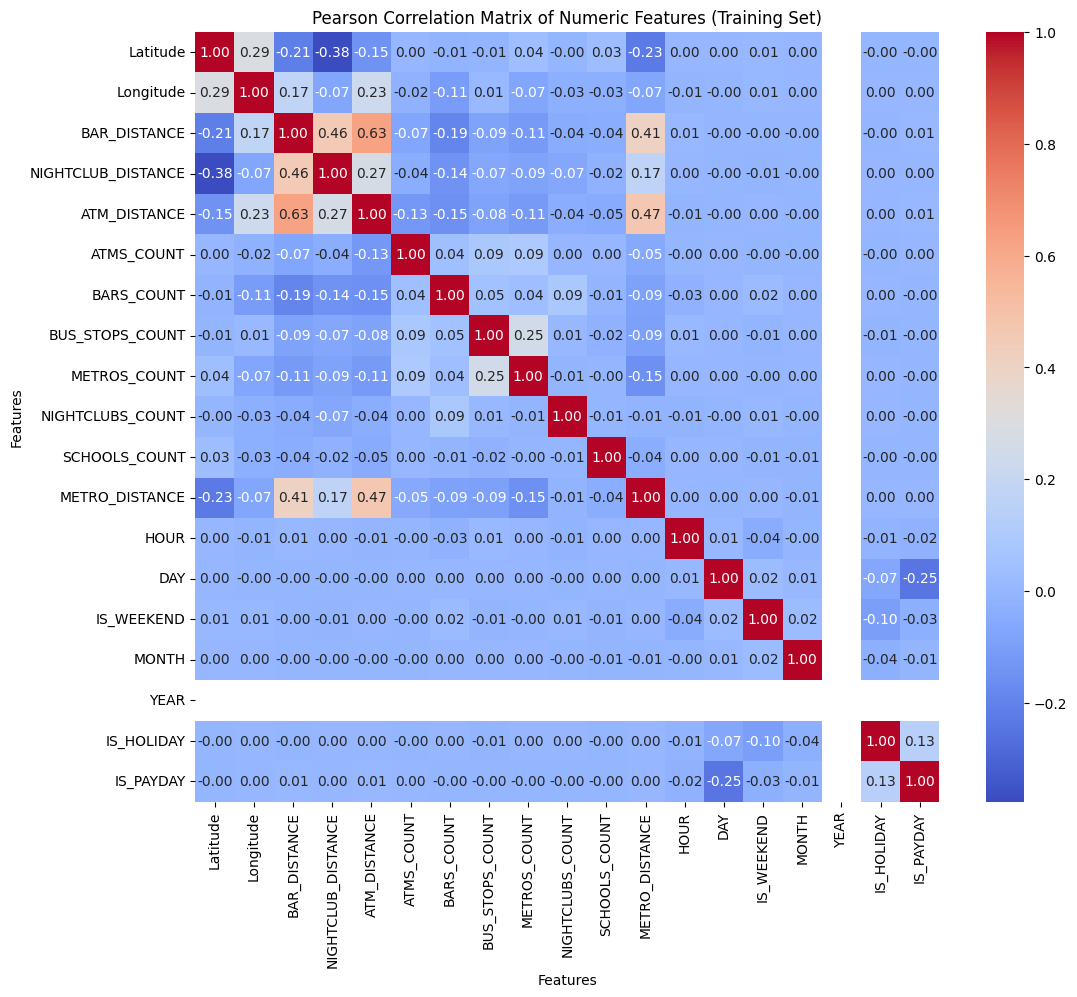

In [12]:
print("\n=== Final Data Scan (Unprocessed Training Data) ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Show a sample of the unprocessed data
print("Sample of X_train (first 5 rows):")
print(X_train.head())

print("\n=== Correlation Matrix (Original Numeric Features in Training Set) ===")
# Re-identify numeric columns in the original X_train
original_numeric_cols = [col for col in X_train.columns if X_train[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

# Calculate Pearson correlation matrix
if original_numeric_cols:
    correlation_matrix = X_train[original_numeric_cols].corr(method='pearson')
# Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title('Pearson Correlation Matrix of Numeric Features (Training Set)')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()
else:
    print("No numeric columns found to calculate correlation matrix.")